In [5]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

# Sentiment Classifier
* Model: 2-layered DNN
* Dataset: Sentiment140 (1.6 million labelled tweets)

## Data preprocessing:
1. Strip HYML tags
2. Remove accented characters
3. Expand contractions
4. remove special chacterests

In [6]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)
    # lower case
    document = document.lower()
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    document = remove_accented_chars(document)
    # expand contractions    
    document = expand_contractions(document)  
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    
    return document


pre_process_corpus = np.vectorize(pre_process_document)

In [7]:
dataset = pd.read_csv('./datasets/tweet_senti_dataset.csv',usecols=[0,1,2,3])

In [ ]:
with open('./datasets/tweet_senti_dataset.csv') as f, open("./datasets/cleaned_tweet_senti_dataset.csv", "w") as cleanedFile:
    for line in f:
        list_line = line.split(',')
        to_write = line
        if line.count(',') > 4:
            list_line = line.split(',')
            string = ','.join(list_line[3:]).replace(',','|')
            new_list = list_line[:3] + [string]
            to_write = ','.join(new_list)
        cleanedFile.write(to_write)
f.close()
cleanedFile.close()
            

In [8]:
dataset.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,0,Sentiment140,is so sad for my APL frie...
1,2,0,Sentiment140,I missed the New Moon trail...
2,3,1,Sentiment140,omg its already 7:30 :O
3,4,0,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,Sentiment140,i think mi bf is cheating on me!!! ...


In [9]:
tweets = dataset['SentimentText'].values
sentiments = dataset['Sentiment'].values

In [10]:
from sklearn.model_selection import train_test_split

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(tweets, sentiments, test_size=.2)

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

In [16]:
train_tweets = pre_process_corpus(x_train)
val_tweets = pre_process_corpus(x_val)
test_tweets = pre_process_corpus(x_test)

In [20]:
train_tweets

array(['and the sweet guys i do meet things turn out bad',
       'drewtoothpaste no worries i do that all the time too many boxes too many boxes',
       'jadennation you might want to change the stills of some of your videos you can see the clues in a few of them ruins the fun',
       ..., 'all on my lonesim da weekend sad',
       'bah i have almost forgotten that project on databases there goes the rest of my day',
       'weekend not going to nyc after all'], dtype='<U748')

In [21]:
import tensorflow as tf
import tensorflow_hub as hub
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': train_tweets},y_train,
    batch_size=256,num_epochs=None,shuffle=True)

predict_train_input_fn = tf.estimator.inputs.numpy_input_fn(
    {'sentence': train_tweets},y_train,shuffle=False)

predict_val_input_fn = tf.estimator.inputs.numpy_input_fn(
{'sentence':val_tweets},y_val,shuffle=False)

predict_test_input_fn = tf.estimator.inputs.numpy_input_fn(
{'sentence':test_tweets},y_test,shuffle=False)

In [22]:
embedding_feature = hub.text_embedding_column(
key='sentence',
module_spec="https://tfhub.dev/google/universal-sentence-encoder/2",
trainable=False)

In [23]:
dnn = tf.estimator.DNNClassifier(
          hidden_units=[512, 128],
          feature_columns=[embedding_feature],
          n_classes=2,
          activation_fn=tf.nn.relu,
          dropout=0.1,
          optimizer=tf.train.AdagradOptimizer(learning_rate=0.005))

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/vp/mcfqh679337_fkjzpr2rv1v80000gn/T/tmpjud5hukx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a210f3ac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/var/folders/vp/mcfqh679337_fkjzpr2rv1v80000gn/T/tmpjud5hukx', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a210f3ac8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [24]:
tf.logging.set_verbosity(tf.logging.ERROR)
import time

TOTAL_STEPS = 1500
STEP_SIZE = 100
for step in range(0, TOTAL_STEPS+1, STEP_SIZE):
    print()
    print('-'*100)
    print('Training for step =', step)
    start_time = time.time()
    dnn.train(input_fn=train_input_fn, steps=STEP_SIZE)
    elapsed_time = time.time() - start_time
    print('Train Time (s):', elapsed_time)
    print('Eval Metrics (Train):', dnn.evaluate(input_fn=predict_train_input_fn))
    print('Eval Metrics (Validation):', dnn.evaluate(input_fn=predict_val_input_fn))


----------------------------------------------------------------------------------------------------
Training for step = 0
Train Time (s): 48.40027093887329
Eval Metrics (Train): {'accuracy': 0.7756782, 'accuracy_baseline': 0.50020784, 'auc': 0.8582227, 'auc_precision_recall': 0.85753816, 'average_loss': 0.4694252, 'label/mean': 0.50020784, 'loss': 60.07929, 'precision': 0.78438747, 'prediction/mean': 0.48877794, 'recall': 0.760623, 'global_step': 100}
Eval Metrics (Validation): {'accuracy': 0.7753732, 'accuracy_baseline': 0.5008809, 'auc': 0.8577252, 'auc_precision_recall': 0.85685873, 'average_loss': 0.4701995, 'label/mean': 0.5008809, 'loss': 60.163383, 'precision': 0.7842802, 'prediction/mean': 0.4889449, 'recall': 0.7607974, 'global_step': 100}

----------------------------------------------------------------------------------------------------
Training for step = 100
Train Time (s): 48.89827013015747
Eval Metrics (Train): {'accuracy': 0.7789079, 'accuracy_baseline': 0.50020784, 

Train Time (s): 45.408324003219604
Eval Metrics (Train): {'accuracy': 0.78955215, 'accuracy_baseline': 0.50020784, 'auc': 0.8730389, 'auc_precision_recall': 0.873585, 'average_loss': 0.44585815, 'label/mean': 0.50020784, 'loss': 57.063065, 'precision': 0.78628594, 'prediction/mean': 0.5079906, 'recall': 0.7954967, 'global_step': 1200}
Eval Metrics (Validation): {'accuracy': 0.7884583, 'accuracy_baseline': 0.5008809, 'auc': 0.8719246, 'auc_precision_recall': 0.87238944, 'average_loss': 0.4475793, 'label/mean': 0.5008809, 'loss': 57.269066, 'precision': 0.785408, 'prediction/mean': 0.50825423, 'recall': 0.7948258, 'global_step': 1200}

----------------------------------------------------------------------------------------------------
Training for step = 1200
Train Time (s): 41.92035412788391
Eval Metrics (Train): {'accuracy': 0.7900965, 'accuracy_baseline': 0.50020784, 'auc': 0.8734748, 'auc_precision_recall': 0.87404835, 'average_loss': 0.4452903, 'label/mean': 0.50020784, 'loss': 56.9

In [25]:
print('Eval Metrics (Test):', dnn.evaluate(input_fn=predict_test_input_fn))

Eval Metrics (Test): {'accuracy': 0.7889922, 'accuracy_baseline': 0.50138885, 'auc': 0.87229156, 'auc_precision_recall': 0.87299764, 'average_loss': 0.44669896, 'label/mean': 0.50138885, 'loss': 57.167873, 'precision': 0.79102546, 'prediction/mean': 0.5010116, 'recall': 0.7870878, 'global_step': 1600}


In [31]:
np.savetxt("./datasets/cleaned_tweets.csv", train_tweets,fmt='%s')

In [32]:
temp = np.append(train_tweets,val_tweets)

In [33]:
temp2 = np.append(temp,test_tweets)

In [34]:
np.savetxt("./datasets/cleaned_tweets.csv", temp2,fmt='%s')

### Save the model to my computer for later use

In [55]:
export_path = "./models/twitter_sentiment_classifier"
feature_placeholder = {'sentence': tf.placeholder('string', [1], name='sentence_placeholder')}
serving_input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn(feature_placeholder)

dnn.export_savedmodel(export_path, serving_input_fn)

b'./models/twitter_sentiment_classifier/1572342502'

### Restore the model from my computer

In [57]:
from tensorflow.contrib import predictor

predict_fn = predictor.from_saved_model("./models/twitter_sentiment_classifier/1572342502")

### Try to predict using the saved model

In [84]:
predictions = predict_fn(
    {"inputs": ["""Fresh from his grilling by the House Financial Services Committee, Facebook founder Mark Zuckerberg arrived at the Paley Center for Media in New York Friday to announce Facebook News, which will curate "high quality" news and information using a combination of both humans and algorithms.

Facebook will pay some publishers millions of dollars a year for access to their journalism. It will include an all-star lineup of what Facebook referred to as trusted sources, including CNN, the Wall Street Journal, the Washington Post, BuzzFeed News, Bloomberg, Fox Business, Business Insider, NPR, the Boston Globe and the LA Times, to name a few. (Facebook also deemed far-right web site Breitbart as a trusted source, which has sparked some controversy).
After years of losing advertisers and readers to the social media platform, the larger publishing industry is undoubtedly excited to be getting paid for its content. Plus, they will finally have access to Facebook's two billion users and steady revenue. But there will likely be some major collateral damage as a result of this deal: The likely obliteration of local news.
News aggregation seems to be all the rage right now. Last week, CNN announced it would launch a digital news service to compete with Facebook and Apple News, and pay news organizations to carry their content. A few months ago, News Corp. announced a similar product called Knewz.
As other news aggregators come to market, it is hard to see why they would have a business motivation to lift up local reporting when shiny national and international brands will be able to fill their feeds with a steady stream of rich, high-quality content that clicks. Readers stay where they can experience a variety of intelligent and compelling content. Aggregators offering such an experience will be able to gather information about the reader the longer they stay, much like Facebook has done for years.
If these news feeds are able to reward smaller news outlets by sharing revenue gains when a local reporting team breaks a big story on toxic schools in Philadelphia or medical insurance fraud in Dallas, then this could work for all news organizations. But to date, the digital transformation has slaughtered local journalism.
The Save Journalism Project reports that more than 7,200 media professionals have lost their jobs in 2019, newsrooms have declined in size by 45% over the past 10 years and 60% of US counties have no local newspaper.
News deserts abound as a result. More than 500 of the 1,800 newspapers that have closed or merged since 2004 were in rural communities, according to a 2018 report from Penny Abernathy, the Knight Chair in Journalism and Digital Media Economics at the University of North Carolina. Pew Research reported that 47% of US adults say "the local news they get mostly covers an area other than where they live." Rural America suffers most as news outlets shutter. In the approaching election year, that seems deeply concerning.
Newsrooms that covered city hall, rogue developments, the people in a community, the local fabric and served as everyday watchdogs have been unable to survive the digital change. I am not talking about the fabled legacy brands that have been thankfully resuscitated and turned digital by wealthy philanthropists like the LA Times, the Boston Globe, the Philadelphia Inquirer and the Washington Post. They will likely survive and prosper with this new aggregation model. It's the other 2,000-plus cities and towns in America with no newsroom left to cover them that I worry about.
This summer, I wrote a paper on local news for the Harvard Kennedy School titled Emerging Models in Local News, which found that digital transformation of local news was happening most where a billionaire owner had stepped in. While there are signs of hope, such as the Minneapolis Star Tribune, the Boston Globe, the LA Times and smaller digital upstarts, like the Richland Source and Texas Tribune, they are far from robust and mostly clustered in thriving cities with the greatest wealth.
MORE TECH & INNOVATION PERSPECTIVES
Facebook's Libra cryptocurrency is a tool for empowerment. Not a threat

I'm developing AI that can read emotions. It's not as creepy as you think.

Big Tech can't be trusted. It's time for regulation

Facebook started 2019 by announcing a $300 million commitment to invest in helping publishers build their readership and subscription models. Advocates for local news will continue to watch closely to see whether Zuckerberg will keep his promise "to focus especially on local news," as he wrote in the New York Times last week.
The irony is that if Zuckerberg's promise is to ensure local news finds eyeballs, there have to actually be local news outlets to aggregate. I would like to see Facebook commit to a ratio model where it subsidizes a certain number of trained journalists at a local newspaper or local NPR station based on the size of that area's population.
Local news owners, including the planned Gannett/GateHouse merger, local television stations and NPR affiliates, with their existing footing in their communities and deep understanding of its history and people, are our last hope. Aggregators like Facebook, CNN and News Corp. need to find a way to make sure local news prospers alongside the national media outlets."""]})
print(predictions['scores'])

[[0.47573274 0.5242672 ]]


## Test results
* Accuracy = ~78.8%

# Financial Tweets and News Data

## Data Transformation
* Indexing the tweets with the scores for negative and positive sentiments, using the sentiment classifier we trained above

* Read tweets csv from computer

In [90]:
tweets = pd.read_json('./datasets/stocknet-dataset/tweet/raw/AAPL/2014-01-01',lines=True)

* toScore takes text as input and output the sentiment score for the text

In [202]:
def preprocessedAndtoSentimentScore(text):
    return predict_fn({'inputs':[pre_process_document(text)]})['scores']
def toScore(text):
    return predict_fn({'inputs':[text]})['scores']

In [200]:
raw_sentiment= tweets['text'].apply(toScore).to_frame()
tweets['negative'] = raw_sentiment['text'].apply(lambda x:x[0][0])
tweets['positive'] = raw_sentiment['text'].apply(lambda x:x[0][1])

In [201]:
cleaned_tweets = tweets[['created_at','negative','positive']]
cleaned_tweets

,created_at,negative,positive
0,2014-01-01 03:59:03+00:00,0.128723,0.871277
1,2014-01-01 03:29:29+00:00,0.128723,0.871277
2,2014-01-01 18:08:47+00:00,0.420018,0.579982
3,2014-01-01 01:52:31+00:00,0.410870,0.589130
4,2014-01-01 01:18:36+00:00,0.128723,0.871277
5,2014-01-01 10:52:20+00:00,0.318260,0.681740
6,2014-01-01 15:01:12+00:00,0.923162,0.076838
7,2013-12-31 23:10:08+00:00,0.128723,0.871277


In [203]:
raw_sentiment= tweets['text'].apply(toScore).to_frame()
tweets['negative'] = raw_sentiment['text'].apply(lambda x:x[0][0])
tweets['positive'] = raw_sentiment['text'].apply(lambda x:x[0][1])
cleaned_tweets = tweets[['created_at','negative','positive']]
cleaned_tweets

,created_at,negative,positive
0,2014-01-01 03:59:03+00:00,0.106284,0.893717
1,2014-01-01 03:29:29+00:00,0.106284,0.893717
2,2014-01-01 18:08:47+00:00,0.585526,0.414474
3,2014-01-01 01:52:31+00:00,0.474725,0.525275
4,2014-01-01 01:18:36+00:00,0.106284,0.893717
5,2014-01-01 10:52:20+00:00,0.215131,0.784869
6,2014-01-01 15:01:12+00:00,0.945209,0.054791
7,2013-12-31 23:10:08+00:00,0.106284,0.893717


Let's try if removing hyperlink would enhance the performance

## Data preprocessing factory
1. remove HTML tags
2. remove accented characters
3. expand the contractions
4. remove special characters
5. remove url
6. remove byte string

### News
* As we have found out, there are some text containing a 'b' in the text. We will add this preprocessing step for news
* That is, we are using steps 1-6

### Tweets
* Using steps 1-5

In [531]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text
def remove_url(text):
    pattern = r'http\S+'
    text = re.sub(pattern, '', text)
    return text
def removeByteString(text):
    if text.startswith('b\'') or text.startswith('b\"'):
        return text[1:]
    return text
def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)
    # lower case
    document = document.lower()
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # remove accented characters
    document = remove_accented_chars(document)
    # expand contractions    
    document = expand_contractions(document)
    #remove hyperlink
    document = remove_url(document)  
    # remove special characters and\or digits    
    # insert spaces between special characters to isolate them    
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
    return document

pre_process_tweet = pre_process_document

pre_process_news = lambda x: pre_process_document(removeByteString(x))

In [221]:
raw_sentiment= tweets['text'].apply(preprocessedAndtoSentimentScore).to_frame()
tweets['negative'] = raw_sentiment['text'].apply(lambda x:x[0][0])
tweets['positive'] = raw_sentiment['text'].apply(lambda x:x[0][1])
cleaned_tweets = tweets[['created_at','negative','positive']]
cleaned_tweets

,created_at,negative,positive
0,2014-01-01 03:59:03+00:00,0.109160,0.890840
1,2014-01-01 03:29:29+00:00,0.109160,0.890840
2,2014-01-01 18:08:47+00:00,0.512257,0.487743
3,2014-01-01 01:52:31+00:00,0.458988,0.541012
4,2014-01-01 01:18:36+00:00,0.109160,0.890840
5,2014-01-01 10:52:20+00:00,0.281334,0.718666
6,2014-01-01 15:01:12+00:00,0.910512,0.089488
7,2013-12-31 23:10:08+00:00,0.109160,0.890840


In [219]:
tweets['text'][6]

'Apple Screwed Up Big Time http://t.co/Q2Pzk2VOMm $AMZN $AAPL'

* The following functions automate the steps for indexing all the tweets in the directory

In [222]:
def preprocessedAndtoSentimentScore(text):
    return predict_fn({'inputs':[pre_process_document(text)]})['scores']
def toScore(text):
    return predict_fn({'inputs':[text]})['scores']
def data_transformation(stock,filename):
    tweets = pd.read_json(f'./datasets/stocknet-dataset/tweet/raw/{stock}/{filename}',lines=True)
    raw_sentiment= tweets['text'].apply(toScore).to_frame()
    tweets['negative_sentiment'] = raw_sentiment['text'].apply(lambda x:x[0][0])
    tweets['positive_sentiment'] = raw_sentiment['text'].apply(lambda x:x[0][1])
    cleaned_tweets = tweets[['created_at','negative_sentiment','positive_sentiment']]
    return cleaned_tweets
def data_preparation(stock):
    import os,re
    r = re.compile('.*-.*-.*')
    aggregated_df = pd.DataFrame(columns=['timestamp','resource_name','asset_name','negative_sentiment','positive_sentiment'])
    for filename in os.listdir(f'./datasets/stocknet-dataset/tweet/raw/{stock}'):
        if r.match(filename):
            result = data_transformation(stock,filename)
            agg_result = pd.DataFrame({
                'timestamp': [filename],
                'resource_name': ['tweets'],
                'asset_name': [stock],
                'negative_sentiment': [result['negative_sentiment'].mean()],
                'positive_sentiment': [result['positive_sentiment'].mean()]
            })
            aggregated_df = aggregated_df.append(agg_result, ignore_index=True)
    pd.to_datetime(aggregated_df.timestamp)
    aggregated_df.sort_values(by=['timestamp'], inplace=True)
    aggregated_df = aggregated_df.reset_index(drop=True)
    return aggregated_df

cleaned_storage_path = lambda stock:f'./datasets/cashcowputer-dataset/{stock}.csv'

In [186]:
stock = 'AAPL'
stock_df = data_preparation(stock)
stock_df.to_csv(cleaned_storage_path(stock),index=False)

In [196]:
visited = list(map(lambda x: x.split('.')[0],os.listdir(f'./datasets/cashcowputer-dataset')))
for stock in os.listdir(f'./datasets/stocknet-dataset/tweet/raw'):
    if stock.isalpha() and stock not in visited:
        data_preparation(stock).to_csv(cleaned_storage_path(stock),index=False)

## News sentiment data

In [342]:
news = pd.read_csv('./datasets/RedditNews.csv')

In [343]:
news.tail()

,Date,News
73603,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...
73604,2008-06-08,b'Threat of world AIDS pandemic among heterose...
73605,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...
73606,2008-06-08,"b""UK: Identity cards 'could be used to spy on ..."
73607,2008-06-08,"b'Marriage, they said, was reduced to the stat..."


In [348]:
def removeByteString(text):
    if text.startswith('b\'') or text.startswith('b\"'):
        return text[1:]
    return text
news['News'] = news['News'].apply(removeByteString)

In [349]:
news.tail()

,Date,News
73603,2008-06-08,'Man goes berzerk in Akihabara and stabs every...
73604,2008-06-08,'Threat of world AIDS pandemic among heterosex...
73605,2008-06-08,'Angst in Ankara: Turkey Steers into a Dangero...
73606,2008-06-08,"""UK: Identity cards 'could be used to spy on p..."
73607,2008-06-08,"'Marriage, they said, was reduced to the statu..."


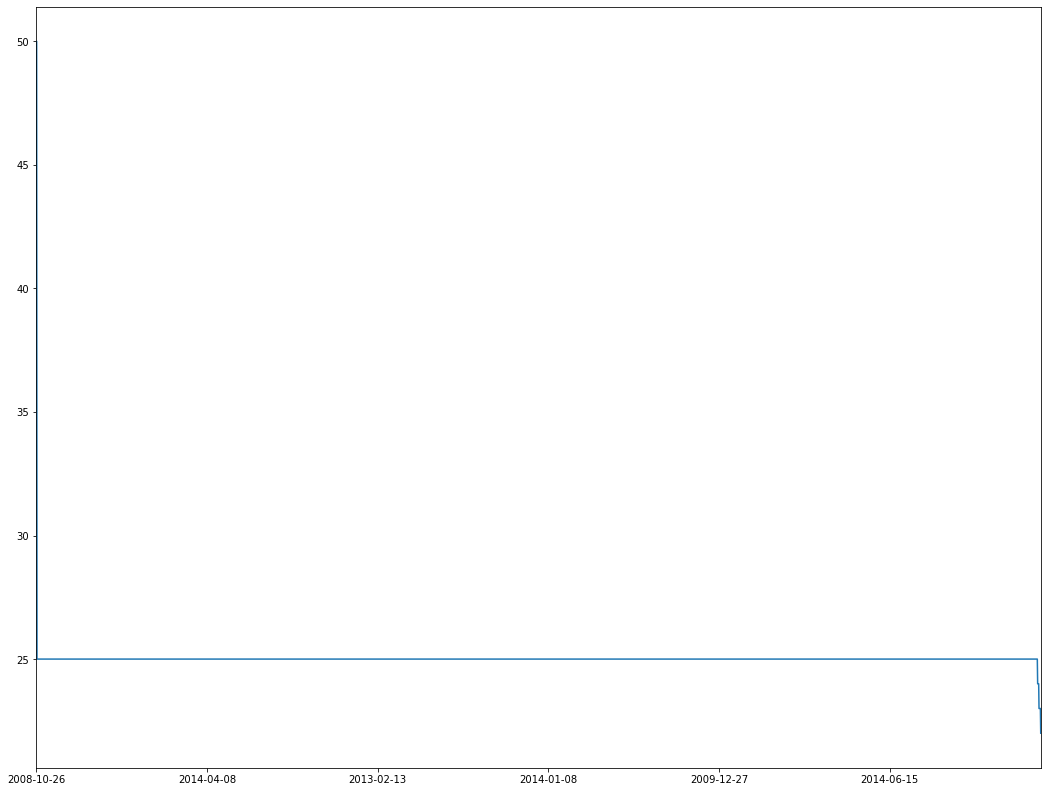

In [288]:
news['Date'].value_counts().plot(kind='line',figsize=(18,14))

#### Possible EDA for next steps:
1. Data cleaning
2. Word frequency
3. Topic modelling

#### important questions:
1. the news article count for each day
2. the time coverage of this dataset

#### interesting questions:
1. what are the most frequent words for each month?
2. what are the most frequent words for each season?
3. what are the most frequent words for each year?
4. what are the most popular topics for each month?
5. what are the most popular topics for each season?
6. what are the most popular topics for each year?

## Time coverage

In [286]:
all_dates = sorted(news['Date'].unique())
start = all_dates[0]
end = all_dates[-1]
start,end

('2008-06-08', '2016-07-01')

## Word frequency exploration
1. By month

In [350]:
news['News'] = news['News'].apply(pre_process_document).to_frame()

In [351]:
news['Date'] = pd.to_datetime(news['Date'])

In [352]:
news_by_year = news.groupby(news.Date.dt.year)
news_by_month = news.groupby([news.Date.dt.year,news.Date.dt.month])
news_by_date = news.groupby(news.Date)

In [353]:
news_by_year.first()

,Date,News
Date,,
2008,2008-12-31,former army employee pleads guilty to acting a...
2009,2009-12-31,czech republic decriminalizes all major drugs ...
2010,2010-12-31,julian assange threatens to name arab leaders ...
2011,2011-12-31,ultraorthodox jewish groups in israel would li...
2012,2012-12-31,a young nepali woman returning from saudi arab...
2013,2013-12-31,the japanese mob is hiring homeless people to ...
2014,2014-12-31,airasia flight found at the bottom of the java...
2015,2015-12-31,microsoft corp said on wednesday it will begin...
2016,2016-07-01,a yearold woman in mexico city finally receive...


In [354]:
news_by_month.first()

Date                                               News
Date Date                                                              
2008 6    2008-06-30  president bush and vice president dick cheney ...
     7    2008-07-31  the international olympic committee agreed to ...
     8    2008-08-31  australian pastor who inspired hundreds of tho...
     9    2008-09-30   gorbachev forms new russian party opposing putin
     10   2008-10-31              british police ask for camera license
...              ...                                                ...
2016 3    2016-03-31  amnesty int has accused qatar of using forced ...
     4    2016-04-30  body of russian soldier who called in an airst...
     5    2016-05-31  every reference to the great barrier reef remo...
     6    2016-06-30  jamaica proposes marijuana dispensers for tour...
     7    2016-07-01  a yearold woman in mexico city finally receive...

[98 rows x 2 columns]

In [355]:
news_by_date.first()

,News
Date,
2008-06-08,nim chimpsky the tragedy of the chimp who thou...
2008-06-09,united states quits human rights council
2008-06-10,oil shortage a myth says industry insider
2008-06-11,bbc uncovers lost iraq billions
2008-06-12,did us attack pakistan last night pakistan fur...
...,...
2016-06-27,barclays and rbs shares suspended from trading...
2016-06-28,scientists to australia if you want to save th...
2016-06-29,explosion at airport in istanbul


In [416]:
#a = datetime(2008,6,2)
#for n in news_by_year.get_group(2008)['News']:
#    print(n)

In [321]:
for group_name, group_values in news_by_year:
    print(group_name)

2008
2009
2010
2011
2012
2013
2014
2015
2016


## Word frequency

### import necessary modules
BoW using gensim module

In [380]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [382]:
len(stopwords.words('english'))

179

### 2008

In [417]:
all_words_2008 = [n for n in news_by_year.get_group(2008)['News']]
all_words_2008 = ' '.join(all_words_2008)
#all_words_2008

In [358]:
tokens = [w for w in word_tokenize(all_words_2008) if w.isalpha()]
no_stops = [t for t in tokens if t not in stopwords.words('english')]
wnl = WordNetLemmatizer()
lemmatized = [wnl.lemmatize (t) for t in no_stops]
Counter(lemmatized).most_common(2)

[('u', 373), ('war', 231)]

In [360]:
Counter(tokens).most_common(2)

[('the', 2256), ('to', 1902)]

In [369]:
from wordcloud import WordCloud 

In [373]:
wordcloud = WordCloud(background_color="white").generate(' '.join(no_stops))

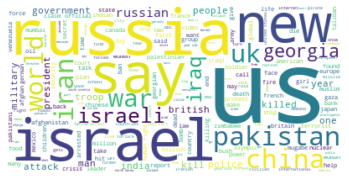

In [374]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

try the stop words library from wordcloud

In [375]:
from wordcloud import STOPWORDS

In [384]:
wc_stopwords = set(STOPWORDS)
len(wc_stopwords)

190

So it has 11 more stop words than the nltk one

Now, let use the wordcloud's one and add more meaningless words to it, .e.g "Say"

In [398]:
wc_stopwords.add("say")
wc_stopwords.add("says")
wc_stopwords.add("year")
wc_stopwords.add("will")

In [399]:
new_tokens = [w for w in word_tokenize(all_words_2008) if w.isalpha()]
new_no_stops = [t for t in new_tokens if t not in wc_stopwords]

In [400]:
Counter(new_no_stops).most_common(2)

[('us', 373), ('s', 264)]

In [401]:
wordcloud1 = WordCloud(background_color="white").generate(' '.join(new_no_stops))

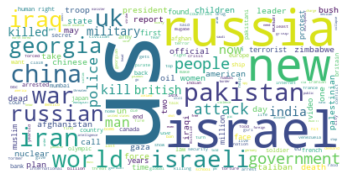

In [402]:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2010

In [418]:
all_words_2010 = [n for n in news_by_year.get_group(2010)['News']]
all_words_2010 = ' '.join(all_words_2010)
#all_words_2010

In [405]:
new_tokens = [w for w in word_tokenize(all_words_2010) if w.isalpha()]
new_no_stops = [t for t in new_tokens if t not in wc_stopwords]

In [406]:
wordcloud1 = WordCloud(background_color="white").generate(' '.join(new_no_stops))

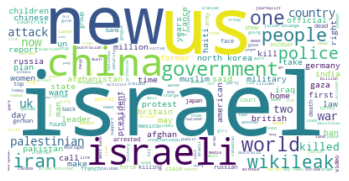

In [407]:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Data Transformation
'timestamp': Date,
'resource_name': news,
'asset_name': ,
'negative_sentiment':
'positive_sentiment': 

In [409]:
news

,Date,News
0,2016-07-01,a yearold woman in mexico city finally receive...
1,2016-07-01,imf chief backs athens as permanent olympic host
2,2016-07-01,the president of france says if brexit won so ...
3,2016-07-01,british man who must give police hours notice ...
4,2016-07-01,nobel laureates urge greenpeace to stop opposi...
...,...,...
73603,2008-06-08,man goes berzerk in akihabara and stabs everyo...
73604,2008-06-08,threat of world aids pandemic among heterosexu...
73605,2008-06-08,angst in ankara turkey steers into a dangerous...
73606,2008-06-08,uk identity cards could be used to spy on peop...


In [410]:
def toScore(text):
    return predict_fn({'inputs':[text]})['scores']

In [411]:
raw_sentiment= news['News'].apply(toScore).to_frame()
news['news_negative_sentiment'] = raw_sentiment['News'].apply(lambda x:x[0][0])
news['news_positive_sentiment'] = raw_sentiment['News'].apply(lambda x:x[0][1])

In [412]:
news.head()

,Date,News,news_negative_sentiment,news_positive_sentiment
0,2016-07-01,a yearold woman in mexico city finally receive...,0.797911,0.202089
1,2016-07-01,imf chief backs athens as permanent olympic host,0.742425,0.257575
2,2016-07-01,the president of france says if brexit won so ...,0.753448,0.246552
3,2016-07-01,british man who must give police hours notice ...,0.770651,0.229349
4,2016-07-01,nobel laureates urge greenpeace to stop opposi...,0.755080,0.244920


# Data scope and schema

* After discussing with groupmates, we have decided to consolidate all the datasets into one and keep one single source of data from this point onwards. The following combines all the data sources and store using consented schemas

* Based on the data avabilable, we have chosen 7 stocks for analysis:

 1. Apple (AAPL)
 2. Google (GOOG)
 3. Amazon (AMZN)
 4. Microsoft (MSFT)
 5. At&T (T)
 6. Intel (INTC)
 7. J.P. Morgan (JPM)


* Time range: 2014-01-01 to 2016-12-31

### 1a. News (title only)

In [481]:
news['title'] = news['News']
news['content'] = news['News']
news['source'] = 'news_title_only'
news['asset'] = 'NA'
news['timestamp'] = news['Date']

In [482]:
news.head()

,Date,News,news_negative_sentiment,news_positive_sentiment,title,content,source,asset,timestamp
0,2016-07-01,a yearold woman in mexico city finally receive...,0.797911,0.202089,a yearold woman in mexico city finally receive...,a yearold woman in mexico city finally receive...,news_title_only,NA,2016-07-01
1,2016-07-01,imf chief backs athens as permanent olympic host,0.742425,0.257575,imf chief backs athens as permanent olympic host,imf chief backs athens as permanent olympic host,news_title_only,NA,2016-07-01
2,2016-07-01,the president of france says if brexit won so ...,0.753448,0.246552,the president of france says if brexit won so ...,the president of france says if brexit won so ...,news_title_only,NA,2016-07-01
3,2016-07-01,british man who must give police hours notice ...,0.770651,0.229349,british man who must give police hours notice ...,british man who must give police hours notice ...,news_title_only,NA,2016-07-01
4,2016-07-01,nobel laureates urge greenpeace to stop opposi...,0.755080,0.244920,nobel laureates urge greenpeace to stop opposi...,nobel laureates urge greenpeace to stop opposi...,news_title_only,NA,2016-07-01


In [483]:
raw_cashcowputer_dataset = news[['timestamp','title','content','source','asset']]

In [484]:
raw_cashcowputer_dataset.head()

,timestamp,title,content,source,asset
0,2016-07-01,a yearold woman in mexico city finally receive...,a yearold woman in mexico city finally receive...,news_title_only,NA
1,2016-07-01,imf chief backs athens as permanent olympic host,imf chief backs athens as permanent olympic host,news_title_only,NA
2,2016-07-01,the president of france says if brexit won so ...,the president of france says if brexit won so ...,news_title_only,NA
3,2016-07-01,british man who must give police hours notice ...,british man who must give police hours notice ...,news_title_only,NA
4,2016-07-01,nobel laureates urge greenpeace to stop opposi...,nobel laureates urge greenpeace to stop opposi...,news_title_only,NA


### 1b. News (whole article) 

In [535]:
combined_news_data = pd.read_csv('./datasets/combined_newsdata.csv')

In [536]:
combined_news_data.date_publish = pd.to_datetime(combined_news_data.date_publish)

In [537]:
combined_news_data.tail()

,date_publish,title,text
337764,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...,NaN
337765,2008-06-08,b'Threat of world AIDS pandemic among heterose...,NaN
337766,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...,NaN
337767,2008-06-08,"b""UK: Identity cards 'could be used to spy on ...",NaN
337768,2008-06-08,"b'Marriage, they said, was reduced to the stat...",NaN


In [538]:
combined_news_data['timestamp'] = combined_news_data['date_publish'].dt.date

In [539]:
combined_news_data.tail()

,date_publish,title,text,timestamp
337764,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...,NaN,2008-06-08
337765,2008-06-08,b'Threat of world AIDS pandemic among heterose...,NaN,2008-06-08
337766,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...,NaN,2008-06-08
337767,2008-06-08,"b""UK: Identity cards 'could be used to spy on ...",NaN,2008-06-08
337768,2008-06-08,"b'Marriage, they said, was reduced to the stat...",NaN,2008-06-08


In [540]:
combined_news_data[combined_news_data['text'].isna()]

,date_publish,title,text,timestamp
1878,2010-01-28 18:00:12,Brief: Tanami,NaN,2010-01-28
8471,2009-11-23 04:34:28,Brief: Quickstep Holdings,NaN,2009-11-23
9570,2017-07-07 00:00:00,"Fairfax's Corbett on dollar, Abbott and Murdoc...",NaN,2017-07-07
15488,2015-08-20 00:00:00,Qantas results - forget cheap fares,NaN,2015-08-20
15644,2015-08-07 00:00:00,Virgin offloads Bali flights to Tiger,NaN,2015-08-07
...,...,...,...,...
337764,2008-06-08 00:00:00,b'Man goes berzerk in Akihabara and stabs ever...,NaN,2008-06-08
337765,2008-06-08 00:00:00,b'Threat of world AIDS pandemic among heterose...,NaN,2008-06-08
337766,2008-06-08 00:00:00,b'Angst in Ankara: Turkey Steers into a Danger...,NaN,2008-06-08
337767,2008-06-08 00:00:00,"b""UK: Identity cards 'could be used to spy on ...",NaN,2008-06-08


In [513]:
combined_news_data['title'].apply(pre_process_news)

0         adrian turner explains how tesla is beating do...
1         afr business summit australian of the year mic...
2         afr business summit day kenneth rogoff hamish ...
3         afr business summit day how the summit wrapped up
4         afr business summit dennis richardson on china...
                                ...                        
337764    bman goes berzerk in akihabara and stabs every...
337765    bthreat of world aids pandemic among heterosex...
337766    bangst in ankara turkey steers into a dangerou...
337767    buk identity cards could be used to spy on peo...
337768    bmarriage they said was reduced to the status ...
Name: title, Length: 337769, dtype: object

In [516]:
combined_news_data['text'].apply(lambda x: pre_process_news(str(x)) if x != None else x)

0         data chief executive adrian turner tells the a...
1         australias leading quantum computing scientist...
2         a question for the panel from the floor direct...
3         and that is it for the financial review busine...
4         dennis richardson former head of the departmen...
                                ...                        
337764                                                  nan
337765                                                  nan
337766                                                  nan
337767                                                  nan
337768                                                  nan
Name: text, Length: 337769, dtype: object

In [541]:
combined_news_data['source'] = combined_news_data['text'].apply(lambda x: 'news_title_only' if type(x) == float and np.isnan(x) else 'news_full')

In [542]:
combined_news_data.tail()

,date_publish,title,text,timestamp,source
337764,2008-06-08,b'Man goes berzerk in Akihabara and stabs ever...,NaN,2008-06-08,news_title_only
337765,2008-06-08,b'Threat of world AIDS pandemic among heterose...,NaN,2008-06-08,news_title_only
337766,2008-06-08,b'Angst in Ankara: Turkey Steers into a Danger...,NaN,2008-06-08,news_title_only
337767,2008-06-08,"b""UK: Identity cards 'could be used to spy on ...",NaN,2008-06-08,news_title_only
337768,2008-06-08,"b'Marriage, they said, was reduced to the stat...",NaN,2008-06-08,news_title_only


In [543]:
combined_news_data['title'] = combined_news_data['title'].apply(pre_process_news)

In [544]:
combined_news_data['content'] = combined_news_data['text'].apply(lambda x: pre_process_news(str(x)) if x != None else x)

In [545]:
combined_news_data.tail()

,date_publish,title,text,timestamp,source,content
337764,2008-06-08,man goes berzerk in akihabara and stabs everyo...,NaN,2008-06-08,news_title_only,nan
337765,2008-06-08,threat of world aids pandemic among heterosexu...,NaN,2008-06-08,news_title_only,nan
337766,2008-06-08,angst in ankara turkey steers into a dangerous...,NaN,2008-06-08,news_title_only,nan
337767,2008-06-08,uk identity cards could be used to spy on peop...,NaN,2008-06-08,news_title_only,nan
337768,2008-06-08,marriage they said was reduced to the status o...,NaN,2008-06-08,news_title_only,nan


In [546]:
combined_news_data.head()

,date_publish,title,text,timestamp,source,content
0,2017-03-21 12:45:00,adrian turner explains how tesla is beating do...,Data 61 chief executive Adrian Turner tells Th...,2017-03-21,news_full,data chief executive adrian turner tells the a...
1,2018-02-16 04:07:09,afr business summit australian of the year mic...,Australia's leading quantum computing scientis...,2018-02-16,news_full,australias leading quantum computing scientist...
2,2018-03-05 02:42:00,afr business summit day kenneth rogoff hamish ...,A question for the panel from the floor; direc...,2018-03-05,news_full,a question for the panel from the floor direct...
3,2019-03-05 08:44:00,afr business summit day how the summit wrapped up,And that's it for the 2019 Financial Review Bu...,2019-03-05,news_full,and that is it for the financial review busine...
4,2018-03-19 12:00:00,afr business summit dennis richardson on china...,"Dennis Richardson, former head of the Departme...",2018-03-19,news_full,dennis richardson former head of the departmen...


In [562]:
combined_news_data.sort_values(by=['timestamp'],inplace=True)

In [563]:
to_store_combined_news_data = combined_news_data[['timestamp','title','content','source']]

In [564]:
to_store_combined_news_data.head()

,timestamp,title,content,source
27100,1987-12-14,in the best of all possible worlds workers des...,beds must be provided to suit the peccadilloes...,news_full
32513,1988-01-08,regular shorts,greenies claim to votes a myth sir in the late...,news_full
26294,1988-04-06,for financial review letterbox for p edition l...,these pages are the opinion section of the aus...,news_full
23674,1988-09-23,annuities lousy investments,residual return bonus return bonus value guara...,news_full
27765,1989-10-31,the latest m buy australian campaign flogs a l...,the instruction to buy australian has a long b...,news_full


In [569]:
to_store_combined_news_data[(to_store_combined_news_data['timestamp'] > pd.to_datetime('2013-12-31')) & (to_store_combined_news_data['timestamp'] < pd.to_datetime('2017-01-01'))]

,timestamp,title,content,source
237911,2014-01-01,business insider,back in clement c moore published the classic ...,news_full
257605,2014-01-01,business insider,how much do million turkeys weigh that is the ...,news_full
240232,2014-01-01,business insider,it is thanksgiving week once again and here at...,news_full
140287,2014-01-01,business insider,if you take time to think about it the sun is ...,news_full
184880,2014-01-01,business insider,now that it is the day after thanksgiving when...,news_full
...,...,...,...,...
249557,2016-12-30,trump putin very smart for not responding to s...,donald trump ralph fresogetty images president...,news_full
184487,2016-12-30,inside the section of the white house where th...,the white house has provided a look at the exe...,news_full
209134,2016-12-31,obamas hesitant approach to foreign policy res...,you s president barack obama pauses during a n...,news_full
13283,2016-12-31,dick smiths demise leaves indelible mark on re...,at kogan com founder ruslan kogans decision to...,news_full


In [570]:
to_store_combined_news_data[(to_store_combined_news_data['timestamp'] > pd.to_datetime('2013-12-31')) & (to_store_combined_news_data['timestamp'] < pd.to_datetime('2017-01-01'))].to_csv('./datasets/cashcowputer-dataset/preprocessed/news/news.csv',index=False)

In [571]:
temp = pd.read_csv('./datasets/cashcowputer-dataset/preprocessed/news/news.csv')
temp.tail()

,timestamp,title,content,source
100086,2016-12-30,trump putin very smart for not responding to s...,donald trump ralph fresogetty images president...,news_full
100087,2016-12-30,inside the section of the white house where th...,the white house has provided a look at the exe...,news_full
100088,2016-12-31,obamas hesitant approach to foreign policy res...,you s president barack obama pauses during a n...,news_full
100089,2016-12-31,dick smiths demise leaves indelible mark on re...,at kogan com founder ruslan kogans decision to...,news_full
100090,2016-12-31,obamacare repeal and replace will not work,mitch mcconnell tim murphy paul ryan cliff owe...,news_full


### 2. Tweets

In [423]:
tweets = pd.read_json('./datasets/stocknet-dataset/tweet/raw/AAPL/2014-01-01',lines=True)

In [424]:
tweets.head()

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,contributors,retweeted_status,retweet_count,favorite_count,entities,favorited,retweeted,filter_level,lang,possibly_sensitive
0,2014-01-01 03:59:03+00:00,418229860210057216,418229860210057216,RT @philstockworld: Summary of Yesterday's Web...,web,False,NaN,NaN,NaN,NaN,...,NaN,{'created_at': 'Tue Dec 31 12:33:51 +0000 2013...,0,0,"{'hashtags': [{'text': 'TraderEducation', 'ind...",False,False,medium,en,NaN
1,2014-01-01 03:29:29+00:00,418222419485421568,418222419485421568,RT @philstockworld: Summary of Yesterday's Web...,web,False,NaN,NaN,NaN,NaN,...,NaN,{'created_at': 'Tue Dec 31 12:33:51 +0000 2013...,0,0,"{'hashtags': [{'text': 'TraderEducation', 'ind...",False,False,medium,en,NaN
2,2014-01-01 18:08:47+00:00,418443702579654656,418443702579654656,iTV Will Boost Apple http://t.co/8dup4cQc08 $A...,"<a href=""http://seekingalpha.com"" rel=""nofollo...",False,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,"{'hashtags': [{'text': 'APPLE', 'indices': [50...",False,False,medium,en,0.0
3,2014-01-01 01:52:31+00:00,418198017015959552,418198017015959552,#iPhone users are more intelligent than #Samsu...,web,False,NaN,NaN,NaN,NaN,...,NaN,NaN,0,0,"{'hashtags': [{'text': 'iPhone', 'indices': [0...",False,False,medium,en,0.0
4,2014-01-01 01:18:36+00:00,418189481607696384,418189481607696384,RT @philstockworld: Summary of Yesterday's Web...,web,False,NaN,NaN,NaN,NaN,...,NaN,{'created_at': 'Tue Dec 31 12:33:51 +0000 2013...,0,0,"{'hashtags': [{'text': 'TraderEducation', 'ind...",False,False,medium,en,NaN


In [444]:
def data_transformation_for_storage(stock,filename):
    tweets = pd.read_json(f'./datasets/stocknet-dataset/tweet/raw/{stock}/{filename}',lines=True)
    raw_sentiment= tweets['text'].apply(pre_process_document).to_frame()
    return raw_sentiment
def data_preparation_for_storage(stock):
    import os,re
    r = re.compile('.*-.*-.*')
    aggregated_df = pd.DataFrame(columns=['timestamp','source','asset','title','content'])
    for filename in os.listdir(f'./datasets/stocknet-dataset/tweet/raw/{stock}'):
        if r.match(filename):
            result = data_transformation_for_storage(stock,filename)
            result['timestamp'] = filename
            result['title'] = result['content'] = result['text']
            result['source'] = 'tweet'
            result['asset'] = stock
            aggregated_df = aggregated_df.append(result, ignore_index=True)
    pd.to_datetime(aggregated_df.timestamp)
    aggregated_df.sort_values(by=['timestamp'], inplace=True)
    aggregated_df = aggregated_df.reset_index(drop=True)
    return aggregated_df[['timestamp','source','asset','title','content']]

In [445]:
dummy = data_preparation_for_storage('AAPL')

In [446]:
dummy.head()

,timestamp,source,asset,title,content
0,2014-01-01,tweet,AAPL,rt philstockworld summary of yesterdays webcas...,rt philstockworld summary of yesterdays webcas...
1,2014-01-01,tweet,AAPL,apple screwed up big time amzn aapl,apple screwed up big time amzn aapl
2,2014-01-01,tweet,AAPL,wrapup and trading set review part iii aapl ap...,wrapup and trading set review part iii aapl ap...
3,2014-01-01,tweet,AAPL,rt philstockworld summary of yesterdays webcas...,rt philstockworld summary of yesterdays webcas...
4,2014-01-01,tweet,AAPL,iphone users are more intelligent than samsung...,iphone users are more intelligent than samsung...


In [458]:
target = ['AAPL','GOOG','AMZN','MSFT','T','INTC','JPM']
temp = pd.DataFrame(columns=['timestamp','source','asset','title','content'])
for stock in target:
    tempDf = data_preparation_for_storage(stock)
    temp = temp.append(tempDf,ignore_index=True)

In [460]:
temp.tail()

,timestamp,source,asset,title,content
49055,2016-03-30,tweet,JPM,commented on jpmorgan chase a bargain in banki...,commented on jpmorgan chase a bargain in banki...
49056,2016-03-30,tweet,JPM,jpmorgan chase co s buy rating reiterated at d...,jpmorgan chase co s buy rating reiterated at d...
49057,2016-03-30,tweet,JPM,options maxpain chart for jpm option invest mo...,options maxpain chart for jpm option invest mo...
49058,2016-03-30,tweet,JPM,commented on jpmorgan chase a bargain in banki...,commented on jpmorgan chase a bargain in banki...
49059,2016-03-31,tweet,JPM,large put buying sbgi jpm mcd wuba fngn lyv pp...,large put buying sbgi jpm mcd wuba fngn lyv pp...


In [477]:
temp[['timestamp','source','asset','content']].to_csv('./datasets/cashcowputer-dataset/preprocessed/tweets/tweets.csv',index=False)

In [478]:
temp1 = pd.read_csv('./datasets/cashcowputer-dataset/preprocessed/tweets/tweets.csv')

In [479]:
temp1.tail()

,timestamp,source,asset,content
49055,2016-03-30,tweet,JPM,commented on jpmorgan chase a bargain in banki...
49056,2016-03-30,tweet,JPM,jpmorgan chase co s buy rating reiterated at d...
49057,2016-03-30,tweet,JPM,options maxpain chart for jpm option invest mo...
49058,2016-03-30,tweet,JPM,commented on jpmorgan chase a bargain in banki...
49059,2016-03-31,tweet,JPM,large put buying sbgi jpm mcd wuba fngn lyv pp...


## Price data
After preparing the sentiment data 

In [572]:
price = pd.read_csv('./datasets/stocknet-dataset/price/raw/AAPL.csv')

In [573]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500


In [574]:
price['Date'] = pd.to_datetime(price['Date'])

In [575]:
price[(price['Date'] > pd.to_datetime('2013-12-31')) & (price['Date'] < pd.to_datetime('2017-01-01'))]

,Date,Open,High,Low,Close,Adj Close,Volume
333,2014-01-02,79.382858,79.575714,78.860001,79.018570,73.522530,58671200
334,2014-01-03,78.980003,79.099998,77.204285,77.282860,71.907555,98116900
335,2014-01-06,76.778572,78.114288,76.228569,77.704285,72.299644,103152700
336,2014-01-07,77.760002,77.994286,76.845711,77.148575,71.782608,79302300
337,2014-01-08,76.972855,77.937141,76.955711,77.637146,72.237190,64632400
...,...,...,...,...,...,...,...
1084,2016-12-23,115.589996,116.519997,115.589996,116.519997,115.088142,14181200
1085,2016-12-27,116.519997,117.800003,116.489998,117.260002,115.819054,18296900
1086,2016-12-28,117.519997,118.019997,116.199997,116.760002,115.325203,20905900
1087,2016-12-29,116.449997,117.110001,116.400002,116.730003,115.295570,15039500


In [577]:
target = ['AAPL','GOOG','AMZN','MSFT','T','INTC','JPM']
temp = pd.DataFrame(columns=['timestamp','asset','Open','Close','Volume'])
for stock in target:
    price = pd.read_csv(f'./datasets/stocknet-dataset/price/raw/{stock}.csv')
    price['asset'] = stock
    price['Date'] = pd.to_datetime(price['Date'])
    price['timestamp'] = price['Date']
    price_filtered = price[(price['Date'] > pd.to_datetime('2013-12-31')) & (price['Date'] < pd.to_datetime('2017-01-01'))]
    temp = temp.append(price_filtered[['timestamp','asset','Open','Close','Volume']],ignore_index=True)

In [580]:
temp.tail()

,timestamp,asset,Open,Close,Volume
5287,2016-12-23,JPM,87.000000,87.050003,10725000
5288,2016-12-27,JPM,87.050003,87.129997,6946400
5289,2016-12-28,JPM,87.160004,86.500000,9455600
5290,2016-12-29,JPM,86.580002,85.889999,14689000
5291,2016-12-30,JPM,86.099998,86.290001,13617800


In [583]:
temp.to_csv('./datasets/cashcowputer-dataset/preprocessed/price/price.csv',index=False)